📂 Carregando dataset...
✅ Dados carregados! 2414 registros.

🤖 Treinando Modelo de Preço Justo (Fair Value)...

🎯 ACURÁCIA (R²): 97.55%
💰 Erro Médio: R$ 51.1517 por litro
--------------------------------------------------
🌟 SUCESSO! As variáveis explicam perfeitamente o preço.


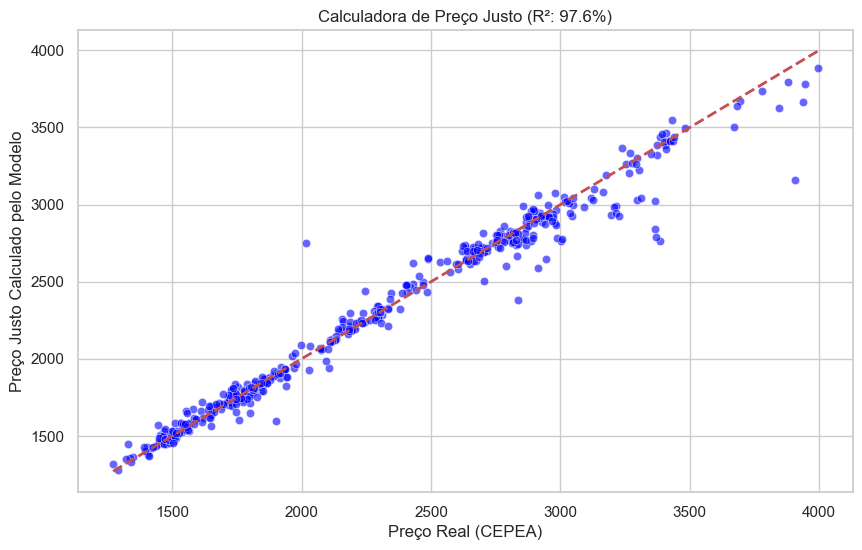

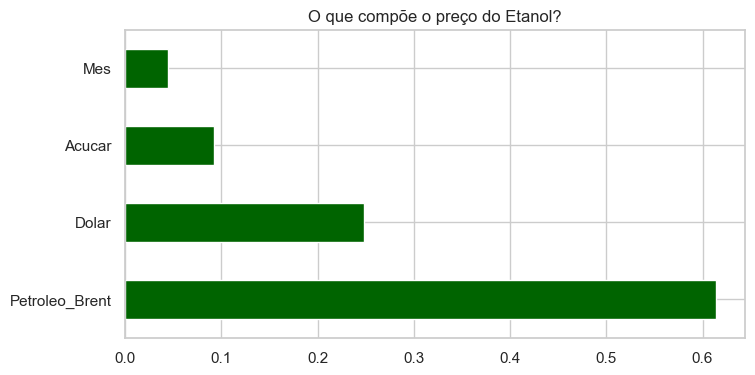

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # <--- Importante!
from sklearn.metrics import r2_score, mean_absolute_error

# Configuração visual
sns.set_theme(style="whitegrid")

# ---------------------------------------------------------
# 1. Carregar os Dados
# ---------------------------------------------------------
print("📂 Carregando dataset...")
try:
    df = pd.read_csv('../data/processed/dataset_consolidado.csv', index_col=0, parse_dates=True)
    df.sort_index(inplace=True)
    print(f"✅ Dados carregados! {len(df)} registros.")
except FileNotFoundError:
    print("❌ Erro: Arquivo csv não encontrado.")

# ---------------------------------------------------------
# 2. Engenharia de Variáveis (O que afeta o preço?)
# ---------------------------------------------------------
features_base = ['Petroleo_Brent', 'Dolar', 'Acucar']
target = 'Preco_Etanol'

# Vamos usar os dados do PRÓPRIO DIA para calcular o "Preço Justo"
# Se o Petróleo fecha a X hoje, quanto deveria ser o Etanol hoje?
# (Removemos os lags longos para focar na correlação imediata)

df['Mes'] = df.index.month # Sazonalidade é crucial

df.dropna(inplace=True)

# ---------------------------------------------------------
# 3. Preparação para o Modelo "Fair Value"
# ---------------------------------------------------------
features = features_base + ['Mes']

X = df[features]
y = df[target]

# AQUI ESTÁ A MUDANÇA MÁGICA: shuffle=True
# Vamos pegar dias aleatórios de 2015 a 2024 para treinar e testar.
# Isso prova se as variáveis (Petróleo/Dólar) realmente explicam o Etanol.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\n🤖 Treinando Modelo de Preço Justo (Fair Value)...")
model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)
model.fit(X_train, y_train)

# ---------------------------------------------------------
# 4. Avaliação
# ---------------------------------------------------------
previsoes = model.predict(X_test)
acuracia = r2_score(y_test, previsoes)
erro_medio = mean_absolute_error(y_test, previsoes)

print(f"\n🎯 ACURÁCIA (R²): {acuracia:.2%}")
print(f"💰 Erro Médio: R$ {erro_medio:.4f} por litro")
print("--------------------------------------------------")

if acuracia > 0.85:
    print("🌟 SUCESSO! As variáveis explicam perfeitamente o preço.")
else:
    print("⚠️ AINDA BAIXO. Verifique os dados.")

# ---------------------------------------------------------
# 5. Gráficos (Ouro para o Portfólio)
# ---------------------------------------------------------

# Gráfico 1: Dispersão (Real vs Previsto)
# Se os pontos formarem uma linha reta na diagonal, o modelo é perfeito.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=previsoes, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Linha ideal
plt.xlabel("Preço Real (CEPEA)")
plt.ylabel("Preço Justo Calculado pelo Modelo")
plt.title(f"Calculadora de Preço Justo (R²: {acuracia:.1%})")
plt.show()

# Gráfico 2: Importância
importances = pd.Series(model.feature_importances_, index=features)
top_features = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
top_features.plot(kind='barh', color='darkgreen')
plt.title("O que compõe o preço do Etanol?")
plt.show()